**Started by Rodrigo Morelatto for testing some data-sets parana basin**

**continued by Andre Ferreira**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy.integrate import cumtrapz

#import seaborn as sns

from __future__ import division

from scipy.signal import bartlett

Our parameters:

1. Sweep frequencies 4 to 86 Hz
2. +1 db per octave (from pictures of the interface of whitehouse and correlation results)
3. 25 seconds sweep length
4. 5 seconds listening 

And a mathemagical expression found by Morelatto on PROMAX for non linear sweeps its instantaneous frequency: 



In [2]:
f1 = 4.
f2 = 86.
SL = 25.
db_oct = 1. # this seams to be the correct!

n = (db_oct)/6. +1
k1 = np.power(f1,n)
k2 = (np.power(f2,n) - np.power(f1,n))/SL

def logs(t): # from PROMAX nonlinear sweeps log - instantaneous frequency
    return np.power((k1 + k2*t),1./n)

def linears(t):
    return f1 + (f2 - f1)/SL*t

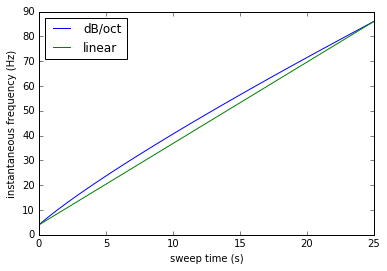

In [3]:
t = np.linspace(0,25,101)
plt.figure()
plt.plot(t,logs(t), label='dB/oct')
plt.plot(t,linears(t), label='linear')
plt.legend(loc='upper left')
plt.xlabel('sweep time (s)')
plt.ylabel(u'instantaneous frequency (Hz)')
plt.show()
plt.close()

The general sweep equation is:

$$S(t) = A_0(t)cos(\phi(t))$$

Given $Sr(t)$ the sweep rate, the instantaneous frequency  of a sweep is given by:

$$ f(t) = f_{min} + \int^{t}_{0}{Sr(x)dx}$$

*The sweep rate $Sr(t) = \frac{df}{dt}$* is a constant function for a linear sweep.*

The instantaneous phase of the sweep is given by:

$$ \phi(t) = 2\pi\int^{t}_{0}{f(y)dy}+\phi_0$$

Than the sweep equation than becomes:

$$S(t) = cos\left[ 2\pi \int^{t}_{0}{\left(  f_{min} + \int^{t}_{0}{Sr(x)dx} + \right) dy}+\phi_0 \right] $$



###Numerically integrating the $\phi(t)$ equation and joining with the first one $S(t)$ we have###

In [4]:
def sweep(t):    
    phase = 2*np.pi*cumtrapz(logs(t), t, initial=0) # numerical integration of \phi(t)
    sweep = np.cos(phase)
    return sweep

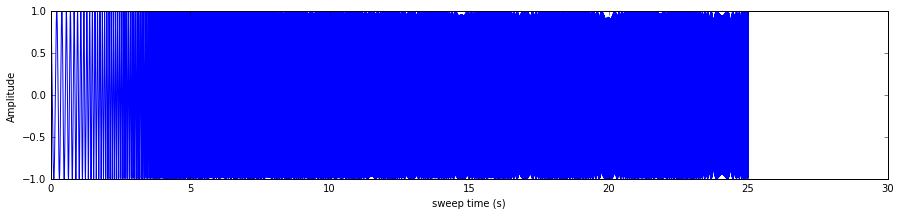

In [5]:
t = np.linspace(0, 25.002, 12500) # 2 miliseconds sample rate
plt.figure(figsize=(15,3))
plt.plot(t, sweep(t))
plt.xlabel('sweep time (s)')
plt.ylabel(u'Amplitude')
plt.show()
plt.close()

###Create the taper 500 ms start and 500 ms end###

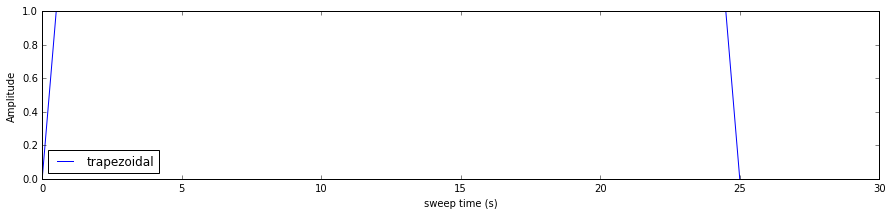

In [6]:
plt.figure(figsize=(15,3))

bar1 = bartlett(1/0.002)[:250]
bar2 = bartlett(1/0.002)[250:]
one = np.ones(12000)
tapper = np.concatenate((bar1,one,bar2))

plt.plot(t,tapper, label='trapezoidal')

plt.legend(loc=3)
plt.xlabel('sweep time (s)')
plt.ylabel(u'Amplitude')

plt.show()
plt.close()

###Apply tapper ###

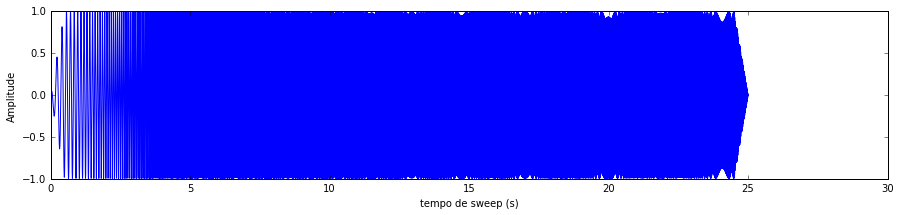

In [7]:
t = np.linspace(0., 25.002, 50000) # 0.5 ms due integration 
sweept = sweep(t) 
# downsample to 2 ms 
from scipy import signal
sweeptd = signal.decimate(sweept, 4) # decimate by 4 to 12500 or 2 ms 
plt.figure(figsize=(15,3))

t = np.linspace(0., 25.002, 12500) 
sweeptd = sweeptd*tapper
plt.plot(t, sweeptd, label='analitico')

plt.xlabel('tempo de sweep (s)')
plt.ylabel(u'Amplitude')

plt.show()
plt.close()

**Testing correlation**

auto correlation size  12500
random series size is  2501
sweep size is   12500
final synthetic trace is  15000
cross correlation size  27499
sweep size is  12500
trace size is  15000
cross correlation size m+n-1  27499
begin of listening is 12499
where is argmin 12499
where is argmax 12699


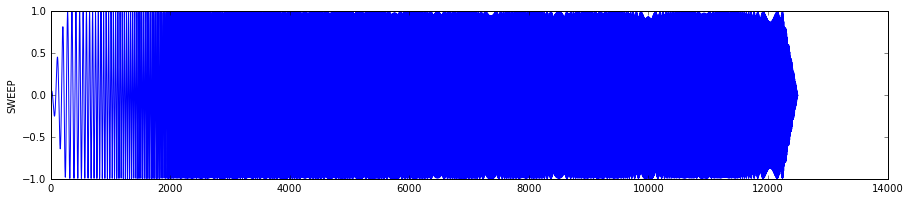

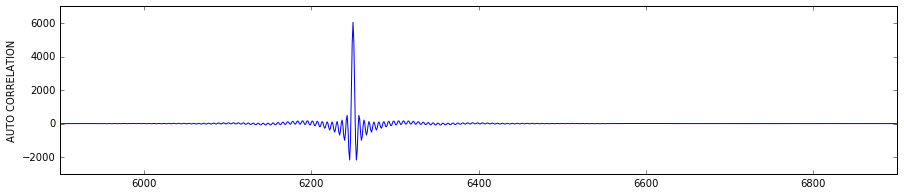

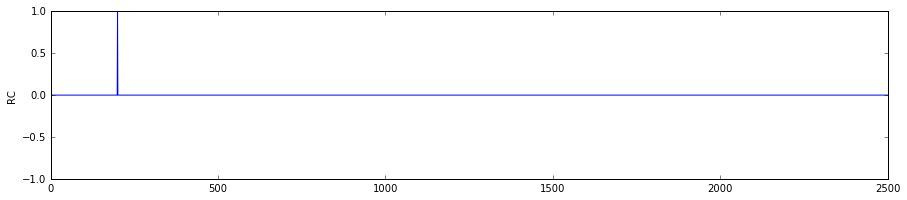

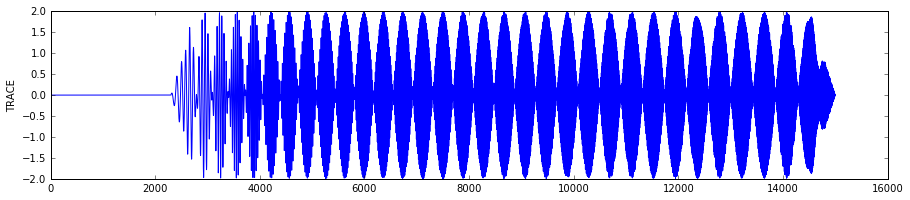

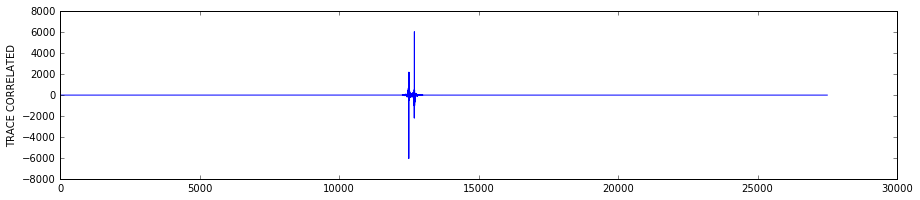

In [8]:
plt.figure(figsize=(15,3))
plt.plot(sweeptd)
plt.ylabel('SWEEP')

plt.figure(figsize=(15,3))
auto = np.correlate(sweeptd, sweeptd, mode='same')
plt.plot(auto)
plt.ylabel('AUTO CORRELATION')
print "auto correlation size ", len(auto)
plt.xlim(5900, 6900)

plt.figure(figsize=(15,3))
rc = np.zeros(2501) # An example reflection series ( 5.002 seconds)
rc[0] = -1.
rc[200] = 1.
plt.plot(rc)
plt.ylabel('RC')

trace = np.correlate(sweeptd, rc, mode='full')
print "random series size is ", len(rc)
print "sweep size is  ", len(sweeptd)
print "final synthetic trace is ", len(trace)
plt.figure(figsize=(15,3))
plt.plot(trace)
plt.ylabel('TRACE')


#tracecorrelated = np.correlate(sweeptd, trace, mode='full') # equal to bellow
#tracecorrelated = np.convolve(sweeptd, trace[::-1], mode='full')
tracecorrelated = signal.fftconvolve(sweeptd, trace[::-1], mode='full')

print 'cross correlation size ', tracecorrelated.size
print 'sweep size is ', sweeptd.size
print 'trace size is ', trace.size
print 'cross correlation size m+n-1 ', sweeptd.size+trace.size-1
print 'begin of listening is', sweeptd.size-1
#xmax = tracecorrelated.argmax()
#print xmax, tracecorrelated.size
plt.figure(figsize=(15,3))
plt.plot(tracecorrelated)
#plt.xlim(12499, 12500+2501)
plt.ylabel('TRACE CORRELATED')

print 'where is argmin', tracecorrelated.argmin()
print 'where is argmax', tracecorrelated.argmax()

In [9]:
cd /home/andre/PycharmProjects/geonumerics

/home/andre/PycharmProjects/geonumerics


###Loaded traces for PV 10131 no correlation or anything like that###

number of traces  1218


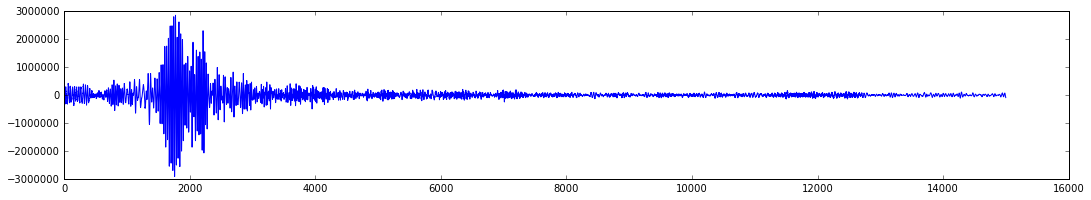

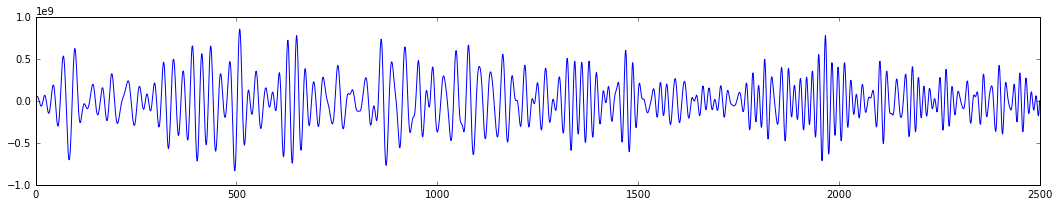

In [10]:
from scipy import signal

# detrend linear 
mtraces = np.load('PV10131_raw.npy')
n,o =  mtraces.shape
print "number of traces ", n
plt.figure(figsize=(18,3))
plt.plot(signal.detrend(mtraces[500,:]))
#plt.xlim(0, 6000)
tr = mtraces[900, :]
xcorr = signal.fftconvolve(sweeptd, signal.detrend(tr)[::-1], mode='full') # correlate with the sweep tapered
plt.figure(figsize=(18, 3)) 
plt.plot(xcorr[12499:12499+2500]) # just 5 seconds = 5./0.002 = 2500

**transpose to work bellow**

In [11]:
mtraces = mtraces.transpose()

In [12]:
mtraces.shape

(15000, 1218)

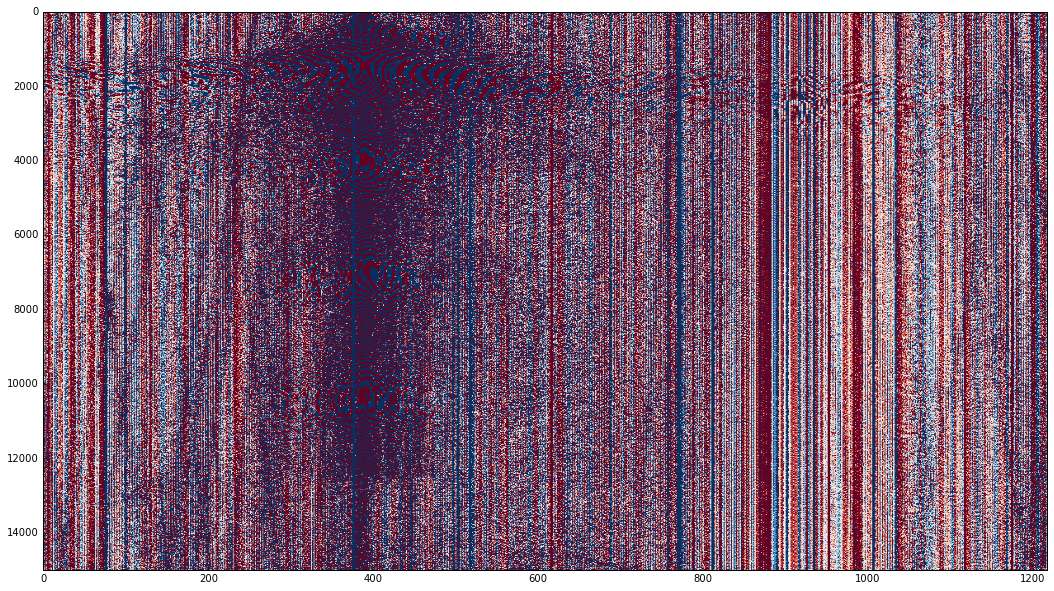

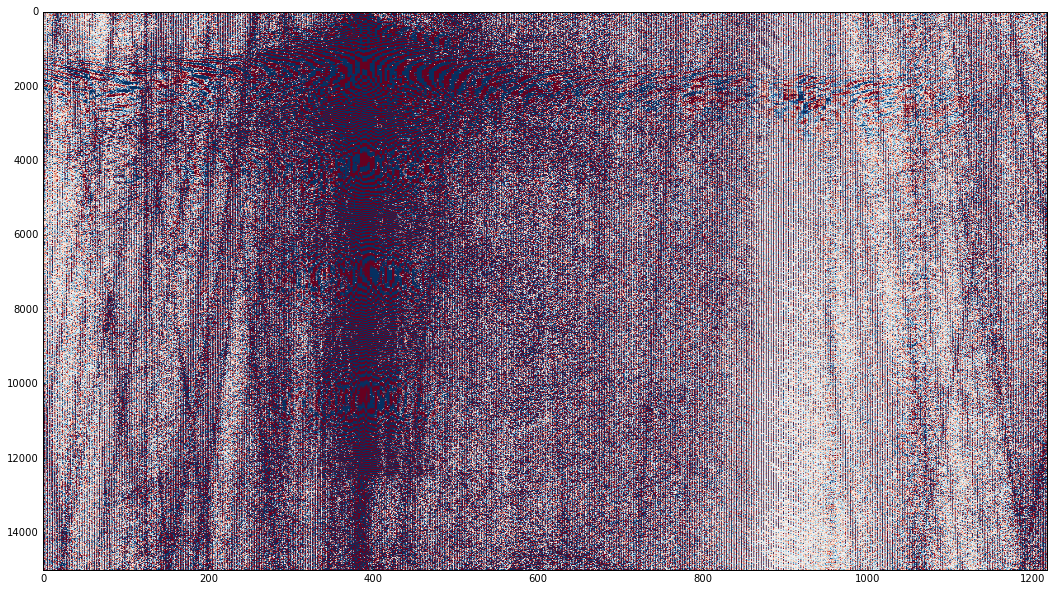

In [13]:
import matplotlib.cm as cm
from scipy import signal

plt.figure(figsize=(18,10))
plt.imshow(mtraces, aspect='auto', vmin=-65*10**3, vmax=65*10**3, cmap=cm.RdBu_r)

#detrend the data linear
mtraces = signal.detrend(mtraces, axis=0, type='constant')
# Then apply a filter on the frequency range 4/86 
# nyquest = 1/2*0.002 = 250 
# filter limits based on nyquest where 1 is nyquest
# [4=0.016, 86=0.344]
# filtering using a IIR (infinite impulse response) recursive filter
b, a = signal.butter(4, (0.012, 0.35), btype='bandpass')
fmtraces = signal.filtfilt(b, a, mtraces, padlen=150, axis=0)
plt.figure(figsize=(18,10))
plt.imshow(fmtraces, aspect='auto', vmin=-65*10**3, vmax=65*10**3, cmap=cm.RdBu_r)

In [14]:
from scipy import signal 
ctraces = np.zeros((27499, n))

for i in range(n):
    trc = fmtraces[:,i]
    ctraces[:, i] = signal.fftconvolve(sweeptd, trc[::-1], mode='full') 
    # correlate with the sweep tapered  

In [ ]:
# shift back by 1 second
plt.figure(figsize=(35,10))
plt.imshow(ctraces[:12500, :], aspect='auto',  vmin=-.05*10**8, vmax=.3*10**8, cmap=cm.Greys_r)

In [48]:
%cd /home/andre/DevPython/fatiando/fatiando
from fatiando.vis.mpl import seismic_wiggle, seismic_image

[Errno 2] No such file or directory: '/home/andre/DevPython/fatiando/fatiando'
/home/andre/PycharmProjects/geonumerics


ImportError: No module named fatiando.vis.mpl

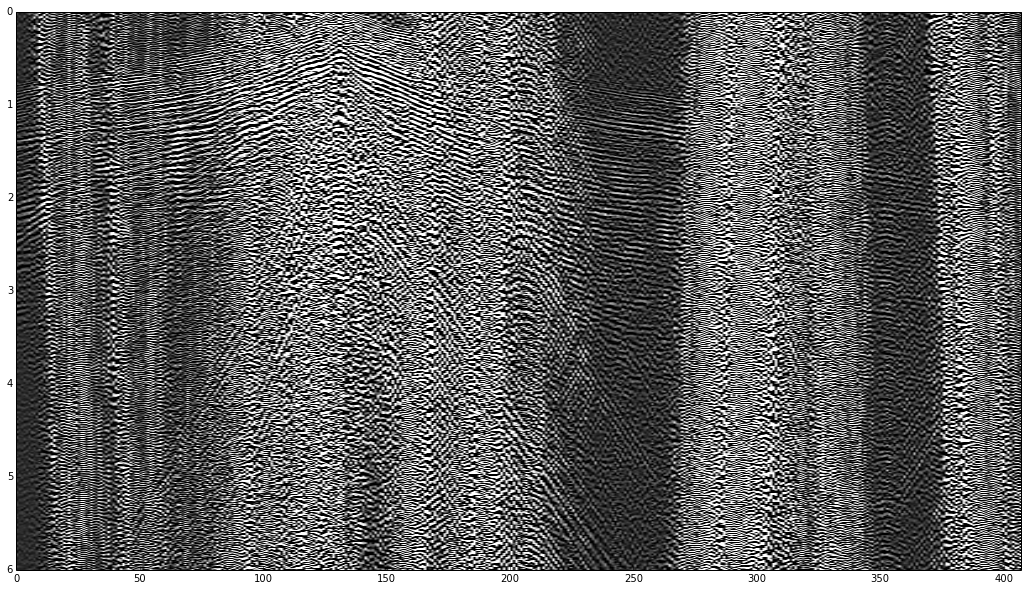

In [45]:
plt.figure(figsize=(18,10))
seismic_image(ctraces[11999:14999,0::3], dt=0.002,  aspect='auto',  vmin=-.05*10**8, vmax=.3*10**8, cmap=cm.Greys_r)

In [ ]:
plt.figure(figsize=(18,10))
seismic_wiggle(ctraces[11999:14999,1::3], dt=0.002, scale=11**(-9))

In [25]:
# 1/t gain or s(t)*t gain
for i in range(n):
    trc = ctraces[:, i]
    #trc = (trc - trc.min())/(trc.max()-trc.min())-.5    
    trc = np.array([trc[j]*(j*0.002) for j in range(len(trc))])
    ctraces[:, i] = trc

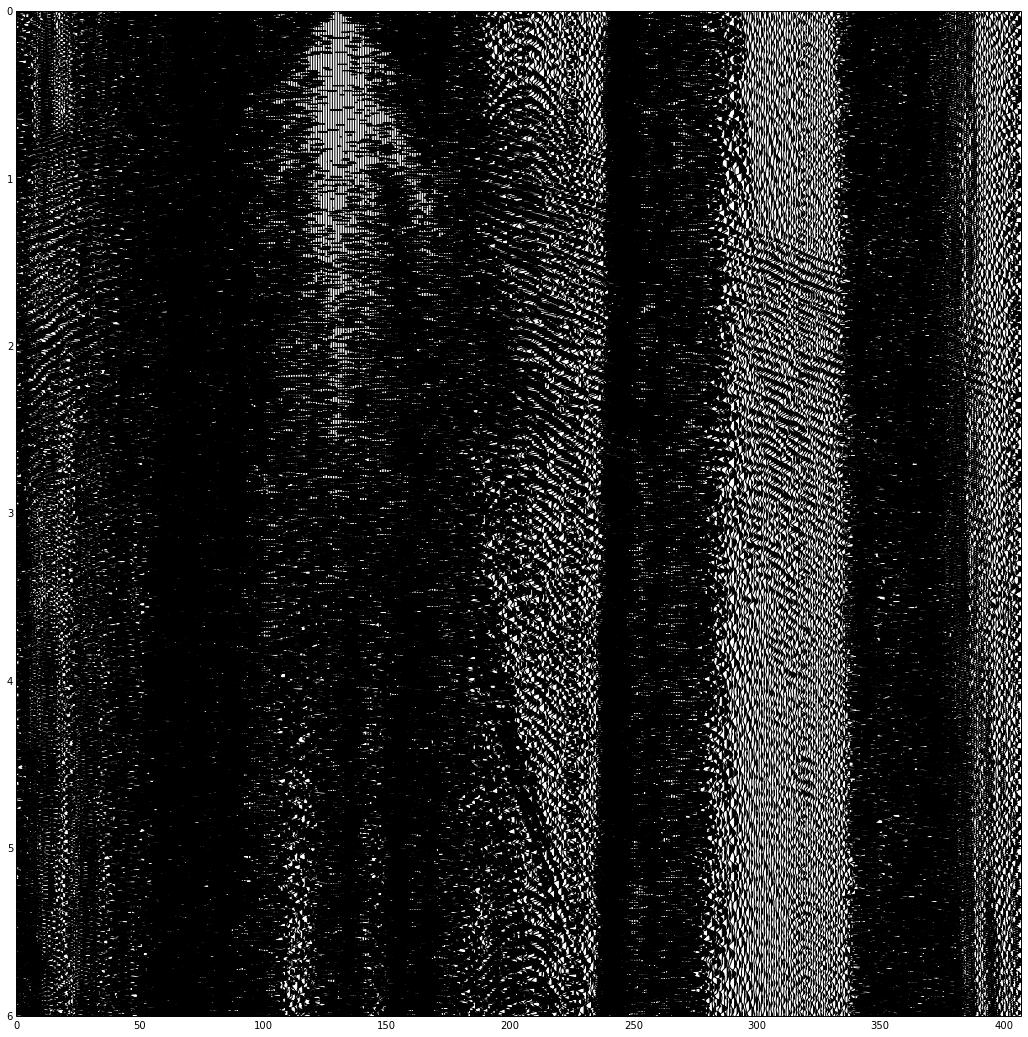

In [43]:
from fatiando.vis.mpl import seismic_wiggle
plt.figure(figsize=(18,18))
# clip to zero very high values, like PROMAX?
clip0 = ctraces.copy()
clip0[ clip0 < -5*10**7 ] = 0.0
clip0[ clip0 > 5*10**7 ] = 0.0
seismic_wiggle(clip0[11999:14999,1::3], dt=0.002, scale=10**(-7))

In [39]:
for i in range(n):
    trc = ctraces[:, i]
    trc = (trc - trc.min())/(trc.max()-trc.min())-.5    
    ctraces[:, i] = trc

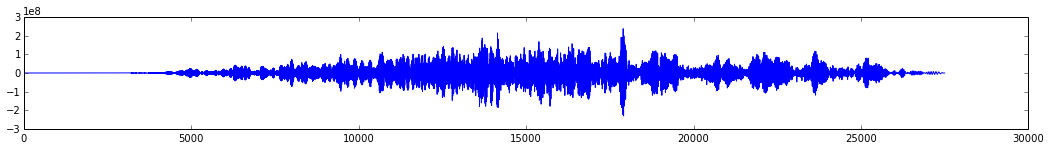

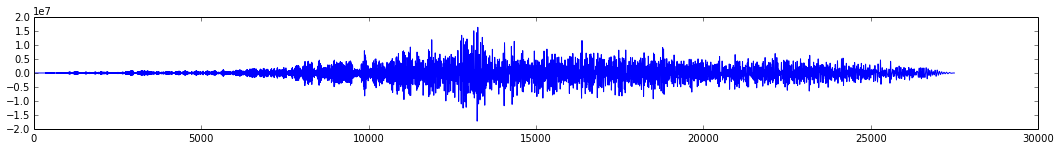

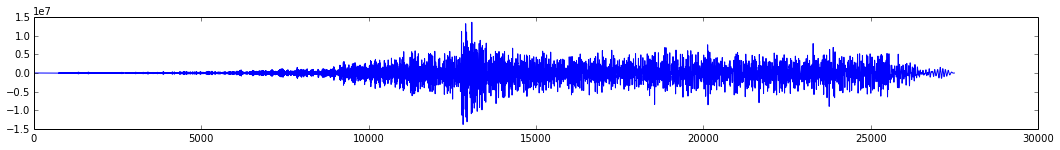

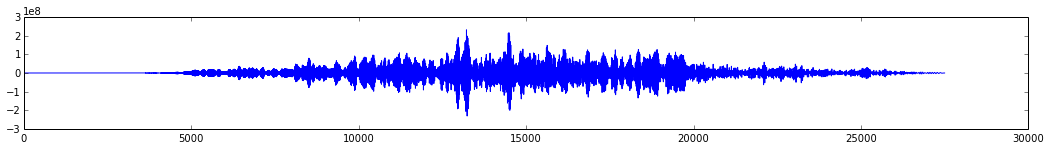

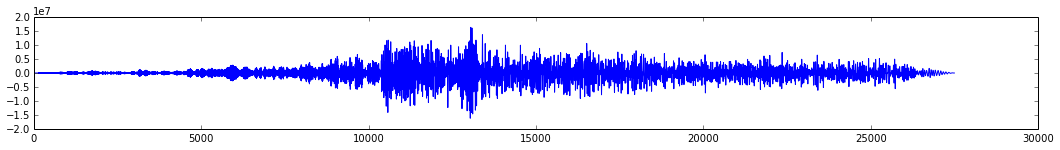

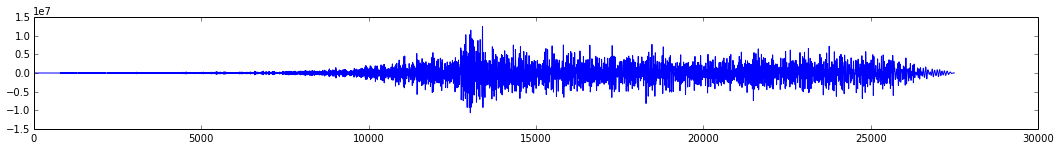

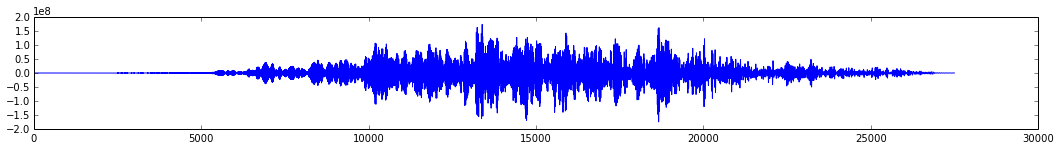

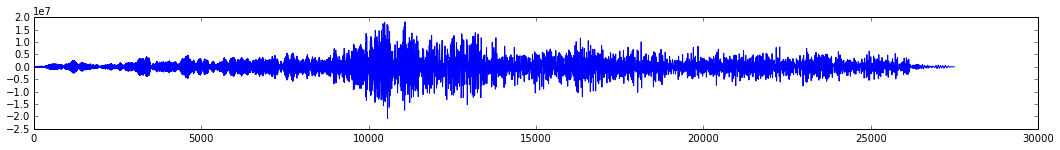

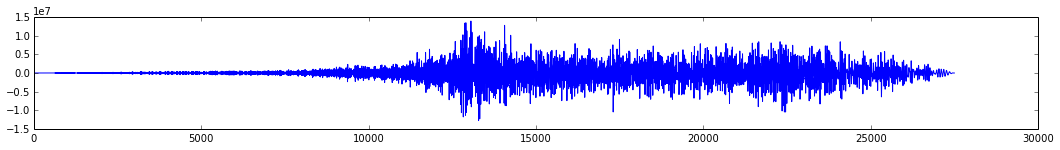

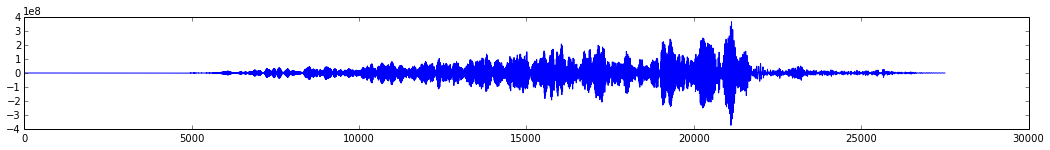

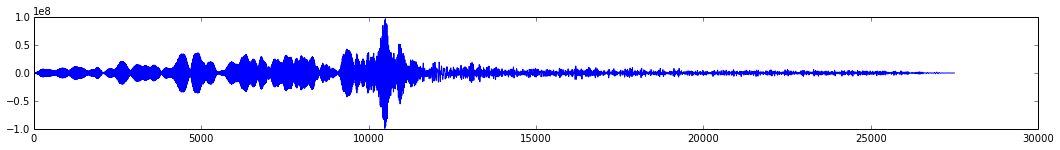

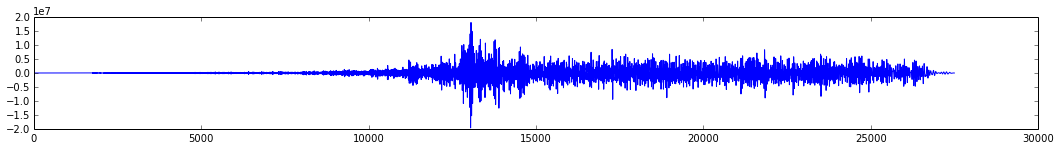

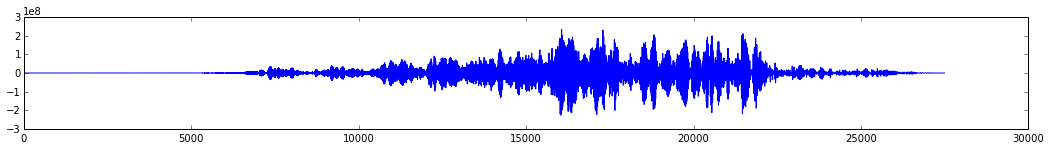

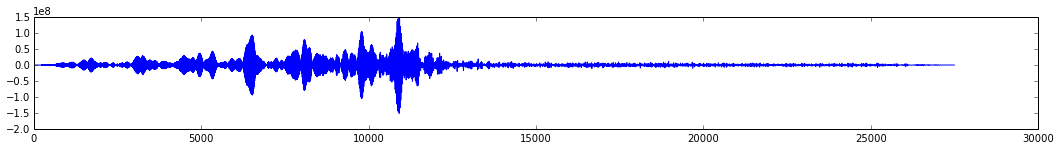

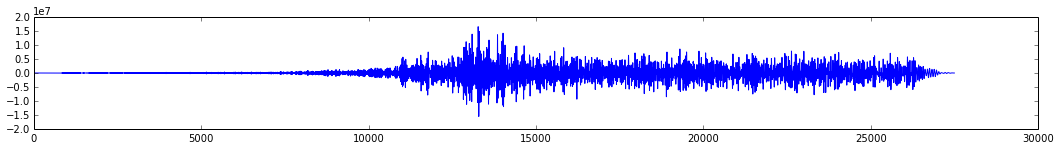

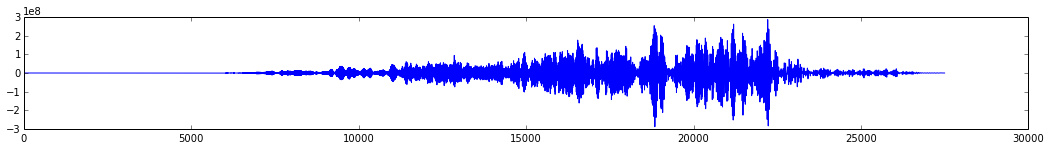

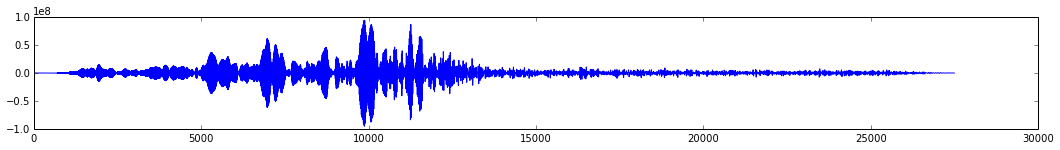

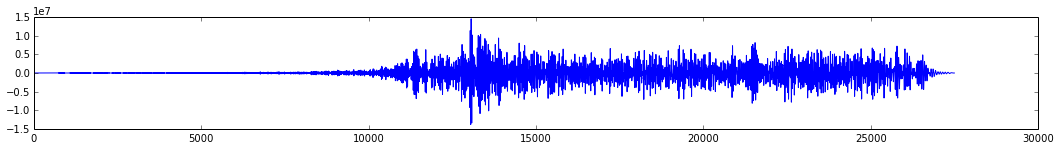

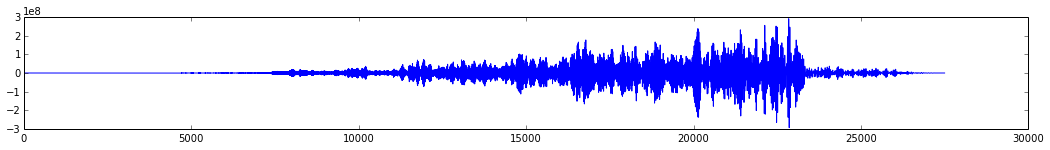

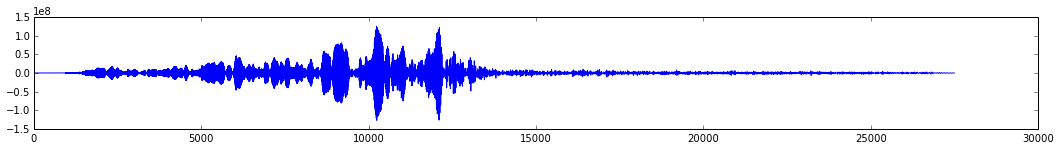

In [23]:
for i in range(20):
    plt.figure(figsize=(18,2))     
    plt.plot(ctraces[:,990+i])